# Model using Keras

# 1. Data Setup

## 1.1. Initial Input

In [5]:
# ============================================================
# 1. Cấu hình thông số
# ============================================================
import os
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Input
from sklearn.preprocessing import MinMaxScaler
import pickle  # Để lưu lịch sử huấn luyện (history)
from IPython.core.interactiveshell import InteractiveShell

# ----- Tham số chính -----
input_steps = 100             # Số bước đầu vào (sliding window input)
output_steps = 1              # Số bước dự đoán đầu ra
file_path = r"./Data/RachMieu1/SETUP4.mat"

# ==== 2. Tham số ====
select_sensor = 1
n_train = 7000
n_val = 1500
n_test = 1500
buffer = input_steps + output_steps  # buffer giữa các tập

step_start = 0
design_samples = n_train + n_val + n_test + 2*buffer
step_finish = step_start + design_samples + (input_steps + output_steps) - 1
print(f"📏 step_start={step_start}, step_finish={step_finish}, "
      f"tổng số sample cần lấy ≈ {design_samples}")

# ============================================================
# 2. Cấu hình hiển thị và làm sạch console
# ============================================================

# Xóa màn hình trước khi chạy lại (Windows / Linux)
os.system('cls' if os.name == 'nt' else 'clear')

# Cho phép hiển thị nhiều output trong cùng một cell (Jupyter)
InteractiveShell.ast_node_interactivity = "all"

# ============================================================
# 3. Đọc dữ liệu từ file .mat
# ============================================================

print(f"🔄 Đang đọc dữ liệu từ file: {file_path}")
data = scipy.io.loadmat(file_path)

# Lọc ra các key có tên dạng 'UntitledXXZ'
keys_to_extract = [key for key in data.keys() if key.startswith("Untitled") and key.endswith("Z")]

print(f"✅ Tìm thấy {len(keys_to_extract)} key hợp lệ trong file .mat")

# Danh sách chứa dữ liệu đã trích xuất
extracted_arrays = []

# Lặp qua từng key để lấy dữ liệu từ trường 'Data'
for key in keys_to_extract:
    raw_value = data[key][0, 0]  # Lấy phần tử đầu tiên trong struct
    if isinstance(raw_value, np.void) and 'Data' in raw_value.dtype.names:
        numerical_array = raw_value['Data']
        # Kiểm tra dữ liệu hợp lệ (2D array)
        if isinstance(numerical_array, np.ndarray) and numerical_array.ndim == 2:
            extracted_arrays.append(numerical_array.flatten())  # Chuyển thành 1D để tiện xử lý

# ============================================================
# 4. Ghép dữ liệu thành ma trận 2D
# ============================================================

if extracted_arrays:
    final_array = np.column_stack(extracted_arrays)  # Ghép thành ma trận 2D (samples x sensors)
    print(f"📊 Kích thước dữ liệu cuối cùng: {final_array.shape} (samples x sensors)")

    # ======  THÊM DÒNG NÀY ĐỂ CẮT DỮ LIỆU  ======
    final_array = final_array[300000:320000, :]  # Cắt từ 300k đến 320k (20k mẫu)
    print(f"Kích thước dữ liệu sau khi cắt: {final_array.shape} (samples x sensors)")

else:
    print(f"⚠️ Không tìm thấy dữ liệu hợp lệ trong file: {file_path}")

print("✅ Hoàn tất xử lý dữ liệu từ file .mat")


📏 step_start=0, step_finish=10302, tổng số sample cần lấy ≈ 10202


0

🔄 Đang đọc dữ liệu từ file: ./Data/RachMieu1/SETUP4.mat
✅ Tìm thấy 4 key hợp lệ trong file .mat
📊 Kích thước dữ liệu cuối cùng: (1058291, 4) (samples x sensors)
Kích thước dữ liệu sau khi cắt: (20000, 4) (samples x sensors)
✅ Hoàn tất xử lý dữ liệu từ file .mat


## 1.2. Dataset (sliding window)

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# ==== 2. Load & chuẩn hóa dữ liệu ====
Data = np.transpose(final_array)  # (sensors, timesteps)
print("Dữ liệu gốc:", Data.shape)

# ==== 3. Cắt dữ liệu gốc ====
Data = Data[:, step_start:step_finish]
print(f"✅ Dữ liệu sau khi slice: {Data.shape[1]} samples, {Data.shape[0]} sensors")

# ==== 4. Chọn sensor ====
Data1 = Data[select_sensor-1, :]
print("Sensor shape:", Data1.shape)

# ==== 5. Hàm tạo sliding window ====
def create_sequences(data, input_steps, output_steps):
    X, y = [], []
    for i in range(len(data) - input_steps - output_steps + 1):
        X.append(data[i:i+input_steps])
        y.append(data[i+input_steps:i+input_steps+output_steps])
    return np.array(X), np.array(y)

# ==== 6. Cắt raw data có buffer ====
train_raw = Data1[: n_train + buffer - 1]
val_raw   = Data1[n_train + buffer : n_train + buffer + n_val + buffer - 1]
test_raw  = Data1[n_train + buffer + n_val + buffer : n_train + buffer + n_val + buffer + n_test + buffer - 1]

print("Train raw shape:", train_raw.shape)
print("Val raw shape:", val_raw.shape)
print("Test raw shape:", test_raw.shape)

# ==== 7. Kiểm tra overlap ====
def check_overlap(a, b, name1, name2):
    if np.array_equal(a[-buffer:], b[:buffer]):
        print(f"⚠️ Overlap giữa {name1} và {name2}")
    else:
        print(f"✅ Không overlap giữa {name1} và {name2}")

check_overlap(train_raw, val_raw, "train", "val")
check_overlap(val_raw, test_raw, "val", "test")

# ==== 8. Tạo sliding window ====
X_train, y_train = create_sequences(train_raw, input_steps, output_steps)
X_val, y_val     = create_sequences(val_raw, input_steps, output_steps)
X_test, y_test   = create_sequences(test_raw, input_steps, output_steps)

# ==== 9. Kết quả ====
print(f"Buffer: {buffer}")
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")


Dữ liệu gốc: (4, 20000)
✅ Dữ liệu sau khi slice: 10302 samples, 4 sensors
Sensor shape: (10302,)
Train raw shape: (7100,)
Val raw shape: (1600,)
Test raw shape: (1600,)
✅ Không overlap giữa train và val
✅ Không overlap giữa val và test
Buffer: 101
Train: (7000, 100), Val: (1500, 100), Test: (1500, 100)


## 1.3. Normalization (Min-Max Scaling)

In [7]:
# Fit scaler từ train
max_scaler = np.max([X_train.max(), y_train.max()])
min_scaler = np.min([X_train.min(), y_train.min()])

print("Scaler fit trên train:")
print("max_scaler =", max_scaler)
print("min_scaler =", min_scaler)

def scale_data(X, y, min_scaler, max_scaler):
    X_scaled = (X - min_scaler) / (max_scaler - min_scaler)
    y_scaled = (y - min_scaler) / (max_scaler - min_scaler)
    return X_scaled, y_scaled

X_train_scaled, y_train_scaled = scale_data(X_train, y_train, min_scaler, max_scaler)
X_val_scaled, y_val_scaled     = scale_data(X_val, y_val, min_scaler, max_scaler)
X_test_scaled, y_test_scaled   = scale_data(X_test, y_test, min_scaler, max_scaler)

# Lưu scaler để predict sau này
np.save("scaler_values.npy", np.array([min_scaler, max_scaler]))


Scaler fit trên train:
max_scaler = 0.039245864721
min_scaler = -0.030624542163


## 1.4. Reshape (samples, timesteps, features)

In [8]:
print("Ket qua truoc khi reshape:")
print("X_train_scaled: " + str(X_train_scaled.shape))
print("X_val_scaled: " + str(X_val_scaled.shape))
print("X_test_scaled: " + str(X_test_scaled.shape))
print("-------------------------------------------")
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], n_features))
X_val_scaled = X_val_scaled.reshape((X_val_scaled.shape[0], X_val_scaled.shape[1], n_features))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], n_features))
print("Ket qua sau khi reshape:")
print("X_train_scaled: " + str(X_train_scaled.shape))
print("X_val_scaled: " + str(X_val_scaled.shape))
print("X_test_scaled: " + str(X_test_scaled.shape))

Ket qua truoc khi reshape:
X_train_scaled: (7000, 100)
X_val_scaled: (1500, 100)
X_test_scaled: (1500, 100)
-------------------------------------------
Ket qua sau khi reshape:
X_train_scaled: (7000, 100, 1)
X_val_scaled: (1500, 100, 1)
X_test_scaled: (1500, 100, 1)


# 2. TCN-LSTM

## 2.1. Model

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Residual Block với dropout tăng và giữ skip connection
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, dilation_rate, dropout_rate=0.3):
        super().__init__()
        self.conv1 = layers.Conv1D(filters, kernel_size, padding='causal',
                                   dilation_rate=dilation_rate, activation='relu')
        self.conv2 = layers.Conv1D(filters, kernel_size, padding='causal',
                                   dilation_rate=dilation_rate, activation='relu')
        self.dropout = layers.Dropout(dropout_rate)
        self.downsample = None
        self.activation = layers.Activation('relu')
        self.filters = filters

    def build(self, input_shape):
        in_channels = input_shape[-1]
        if in_channels != self.filters:
            self.downsample = layers.Conv1D(self.filters, 1)
        super().build(input_shape)

    def call(self, x, training=False):
        residual = x
        if self.downsample is not None:
            residual = self.downsample(x)
        x = self.conv1(x)
        x = self.dropout(x, training=training)
        x = self.conv2(x)
        x = self.dropout(x, training=training)
        return self.activation(x + residual)

# Model TCN + LSTM tối ưu
class TCN_LSTM_Model(tf.keras.Model):
    def __init__(self, num_blocks=4, filters=64, kernel_size=3, target_len=5):
        super().__init__()
        # === TCN blocks ===
        tcn_layers = []
        for i in range(num_blocks):
            dilation_rate = 2 ** i
            tcn_layers.append(ResidualBlock(filters, kernel_size, dilation_rate))
        self.tcn_blocks = tf.keras.Sequential(tcn_layers)

        # LayerNormalization để ổn định đầu ra
        self.norm_tcn = layers.LayerNormalization()

        # === LSTM layers (giảm từ 4 còn 3 tầng) ===
        self.lstm1 = layers.LSTM(128, return_sequences=True, dropout=0.3)
        self.dropout_lstm1 = layers.Dropout(0.2)
        self.lstm2 = layers.LSTM(64, return_sequences=True, dropout=0.3)
        self.dropout_lstm2 = layers.Dropout(0.2)
        self.lstm3 = layers.LSTM(32, return_sequences=False, dropout=0.3)

        # === Dense layers có BatchNormalization ===
        self.bn1 = layers.BatchNormalization()
        self.fc1 = layers.Dense(128, activation='relu')
        self.dropout_fc1 = layers.Dropout(0.3)

        self.bn2 = layers.BatchNormalization()
        self.fc2 = layers.Dense(64, activation='relu')
        self.dropout_fc2 = layers.Dropout(0.3)

        # Output
        self.out = layers.Dense(target_len)

    def call(self, x, training=False):
        # TCN + normalization
        x = self.tcn_blocks(x, training=training)
        x = self.norm_tcn(x)

        # LSTM stack
        x = self.lstm1(x, training=training)
        x = self.lstm2(x, training=training)
        x = self.lstm3(x, training=training)

        # Fully connected
        x = self.bn1(x, training=training)
        x = self.fc1(x)
        x = self.dropout_fc1(x, training=training)

        x = self.bn2(x, training=training)
        x = self.fc2(x)
        x = self.dropout_fc2(x, training=training)

        return self.out(x)


## 2.2. Training

In [11]:
import time
import pandas as pd
import tensorflow as tf

# === 1. Khởi tạo & Build model ===
model1 = TCN_LSTM_Model(
    num_blocks=4,         # số block TCN
    filters=64,           # số filter trong mỗi block
    kernel_size=3,        # kernel size của Conv1D
    target_len=output_steps
)
model1.build(input_shape=(None, input_steps, 1))
model1.summary()

# === 2. Compile model ===
model1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

# === 3. Callbacks ===
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=30,               # cho phép model học lâu hơn trước khi dừng
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,                # giảm lr một nửa nếu không cải thiện
    patience=10,
    min_lr=1e-6,
    verbose=1
)

csv_logger = tf.keras.callbacks.CSVLogger(
    "training_log_model1.csv",
    append=False
)

# === 4. Đo thời gian huấn luyện ===
start_time = time.time()

# === 5. Fit model ===
history1 = model1.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop, reduce_lr, csv_logger],  # ❌ bỏ checkpoint
    verbose=1
)

training_time = round(time.time() - start_time, 2)
print(f"✅ Huấn luyện hoàn tất sau {training_time} giây.")

# === 6. Lưu thời gian ra file CSV ===
pd.DataFrame({"Training Time (s)": [training_time]}).to_csv(
    "training_time_model1.csv",
    index=False
)

# === 7. Đánh giá trên validation và in ra kết quả ===
val_loss, val_mae = model1.evaluate(X_val_scaled, y_val_scaled, verbose=0)
print(f"📊 Kết quả trên tập validation: val_loss={val_loss:.6f}, val_mae={val_mae:.6f}")


/home/vudxlab/miniconda3/envs/tcn_lstm/lib/python3.10/site-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'tcn_lstm__model_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "tcn_lstm__model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ ?                      │   0 (unbuilt) │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 18s 96ms/step - loss: 0.5911 - mean_absolute_error: 0.5855 - val_loss: 0.0851 - val_mean_absolute_error: 0.2793 - learning_rate: 0.0010
Epoch 2/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - loss: 0.2075 - mean_absolute_error: 0.3560 - val_loss: 0.0625 - val_mean_absolute_error: 0.2353 - learning_rate: 0.0010
Epoch 3/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - loss: 0.1099 - mean_absolute_error: 0.2589 - val_loss: 0.0300 - val_mean_absolute_error: 0.1556 - learning_rate: 0.0010
Epoch 4/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - loss: 0.0667 - mean_absolute_error: 0.2012 - val_loss: 0.0183 - val_mean_absolute_error: 0.1178 - learning_rate: 0.0010
Epoch 5/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - loss: 0.0480 - mean_absolute_error: 0.1722 - val_loss: 0.0220 - val_mean_absolute_error: 0.1309 - learning_rate: 0.0010
Epoch 6/100
110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - loss: 0.0377 - mean_absolute_error: 0.1524 - val_loss: 0.0168 -

## 2.3. Save

In [13]:
import pickle
import pandas as pd

# === 1. Lưu mô hình dưới dạng TensorFlow SavedModel (phù hợp với TF 2.10.1) ===
# model1.save("model1_saved", save_format="tf")  # Lưu dưới dạng thư mục


# === 2. Lưu lịch sử huấn luyện (history) bằng pickle để dùng vẽ biểu đồ sau ===
with open("history1_saved.pkl", "wb") as f:
    pickle.dump(history1.history, f)


## 2.4. Plot

<Figure size 1000x500 with 0 Axes>

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss (MSE)')

Text(0.5, 1.0, 'Training and Validation MSE Loss')

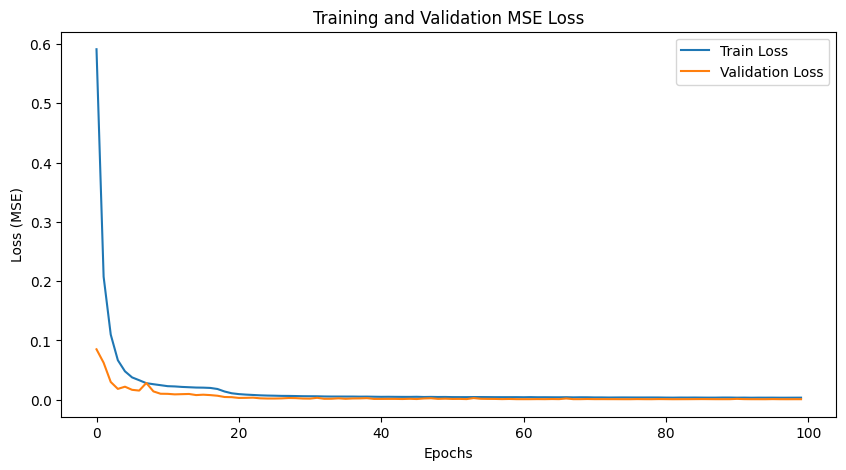

<Figure size 1000x500 with 0 Axes>

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'MAE')

Text(0.5, 1.0, 'Training and Validation MAE')

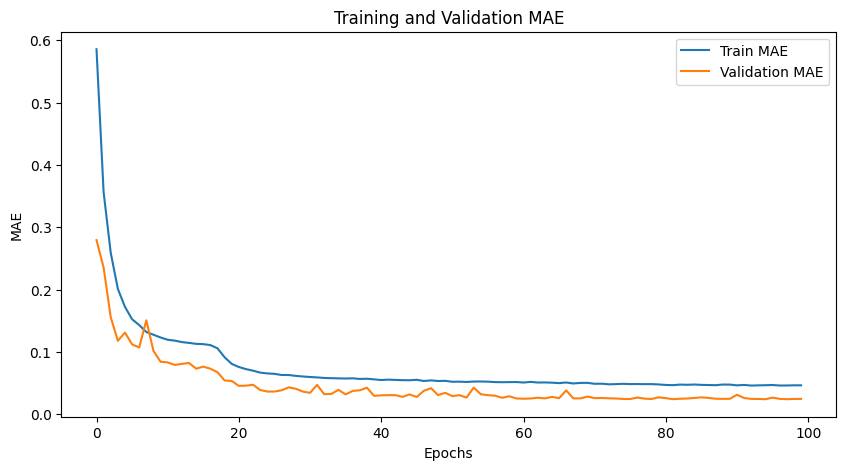

In [14]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ Loss MSE
plt.figure(figsize=(10, 5))
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation MSE Loss')
plt.legend()
plt.show()

# Vẽ biểu đồ MAE
plt.figure(figsize=(10, 5))
plt.plot(history1.history['mean_absolute_error'], label='Train MAE')
plt.plot(history1.history['val_mean_absolute_error'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')
plt.legend()
plt.show()

## 2.5. Evaluation

In [15]:
import numpy as np
# 1. Đánh giá mô hình trên tập test (evaluate)
test_loss1 = model1.evaluate(X_test_scaled, y_test_scaled, verbose=0)
print(f'Test Loss: {test_loss1}')

# 2. Đánh giá hiệu suất bằng các chỉ số (RMSE, MAE, R²)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Dự đoán trên tập train, validate, test
y_train_pred_scaled1 = model1.predict(X_train_scaled)
y_val_pred_scaled1   = model1.predict(X_val_scaled)
y_test_pred_scaled1  = model1.predict(X_test_scaled)

# MinMaxScaler trả về giá trị thật để đánh giá: Xreal = X'*(Max - Min) + Min
y_train_real = y_train_scaled * (max_scaler - min_scaler) + min_scaler
y_val_real   = y_val_scaled   * (max_scaler - min_scaler) + min_scaler
y_test_real  = y_test_scaled  * (max_scaler - min_scaler) + min_scaler
#print("Average value of train data = " + str(np.mean(y_train_real)))
#print("Average value of val data = " + str(np.mean(y_val_real))) 
#print("Average value of test data = " + str(np.mean(y_test_real)))

y_train_pred1 = y_train_pred_scaled1 * (max_scaler - min_scaler) + min_scaler
y_val_pred1   = y_val_pred_scaled1   * (max_scaler - min_scaler) + min_scaler
y_test_pred1  = y_test_pred_scaled1  * (max_scaler - min_scaler) + min_scaler

# Tính chỉ số cho tập train
rmse_train1 = np.sqrt(mean_squared_error(y_train_real, y_train_pred1))
mae_train1  = mean_absolute_error(y_train_real, y_train_pred1)
r2_train1   = r2_score(y_train_real, y_train_pred1)

# Tính chỉ số cho tập validate
rmse_val1 = np.sqrt(mean_squared_error(y_val_real, y_val_pred1))
mae_val1  = mean_absolute_error(y_val_real, y_val_pred1)
r2_val1   = r2_score(y_val_real, y_val_pred1)

# Tính chỉ số cho tập test
rmse_test1 = np.sqrt(mean_squared_error(y_test_real, y_test_pred1))
mae_test1  = mean_absolute_error(y_test_real, y_test_pred1)
r2_test1   = r2_score(y_test_real, y_test_pred1)
# R² = 1: Mô hình hoàn hảo. R² > 0.9: Mô hình tốt. R² < 0.5: Mô hình chưa tốt, cần cải thiện.

# In kết quả
print("Đánh giá mô hình:")
print(f"Train   - RMSE: {rmse_train1:.5f}, MAE: {mae_train1:.5f}, R²: {r2_train1:.5f}")
print(f"Validate- RMSE: {rmse_val1:.5f}, MAE: {mae_val1:.5f}, R²: {r2_val1:.5f}")
print(f"Test    - RMSE: {rmse_test1:.5f}, MAE: {mae_test1:.5f}, R²: {r2_test1:.5f}")

# Lưu kết quả đánh giá mô hình Train, Validate và Test thành file *csv mở như excel
import pandas as pd
# Tạo DataFrame chứa các chỉ số
metrics1_df = pd.DataFrame({
    "Dataset": ["Train", "Validation", "Test"],
    "RMSE": [rmse_train1, rmse_val1, rmse_test1],
    "MAE":  [mae_train1, mae_val1, mae_test1],
    "R2":   [r2_train1, r2_val1, r2_test1]
})
# Lưu vào file CSV
metrics1_df.to_csv("metrics_model1.csv", index=False)
print("Metrics saved to metrics_model1.csv")


Test Loss: [0.0006666483241133392, 0.02060071751475334]
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Đánh giá mô hình:
Train   - RMSE: 0.00358, MAE: 0.00278, R²: 0.86283
Validate- RMSE: 0.00212, MAE: 0.00169, R²: 0.87312
Test    - RMSE: 0.00180, MAE: 0.00144, R²: 0.92888
Metrics saved to metrics_model1.csv


In [16]:
import tensorflow as tf

# Xóa session hiện tại để giải phóng graph và GPU memory
tf.keras.backend.clear_session()

# 3. TCN

## 3.1. Model

In [17]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Residual Block cho TCN
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, dilation_rate, dropout_rate=0.2):
        super().__init__()
        self.conv1 = layers.Conv1D(filters, kernel_size, padding='causal',
                                   dilation_rate=dilation_rate)
        self.relu1 = layers.Activation('relu')
        self.dropout1 = layers.Dropout(dropout_rate)

        self.conv2 = layers.Conv1D(filters, kernel_size, padding='causal',
                                   dilation_rate=dilation_rate)
        self.relu2 = layers.Activation('relu')
        self.dropout2 = layers.Dropout(dropout_rate)

        self.downsample = None
        self.final_relu = layers.Activation('relu')
        self.filters = filters

    def build(self, input_shape):
        in_channels = input_shape[-1]
        if in_channels != self.filters:
            self.downsample = layers.Conv1D(self.filters, kernel_size=1, padding='same')
        super().build(input_shape)

    def call(self, x, training=False):
        residual = x
        if self.downsample is not None:
            residual = self.downsample(x)

        x = self.conv1(x)
        x = self.relu1(x)
        x = self.dropout1(x, training=training)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.dropout2(x, training=training)

        return self.final_relu(x + residual)

# TCN Model
class TCN_Model(tf.keras.Model):
    def __init__(self, num_blocks=1, filters=16, kernel_size=2, target_len=1): 
        super().__init__()

        self.tcn_blocks = tf.keras.Sequential()
        for i in range(num_blocks):
            dilation_rate = 2 ** i
            self.tcn_blocks.add(ResidualBlock(filters, kernel_size, dilation_rate))

        # Lấy bước thời gian cuối cùng
        self.last_time_step = layers.Lambda(lambda x: x[:, -1, :])  # shape (batch, features)

        # Fully connected layers
        #self.fc1 = layers.Dense(128, activation='relu')
        #self.fc2 = layers.Dense(64, activation='relu')
        self.out = layers.Dense(target_len)  # output sequence

    def call(self, x, training=False):
        x = self.tcn_blocks(x, training=training)  # (batch, time, filters)
        x = self.last_time_step(x)                 # (batch, filters)
        #x = self.fc1(x)
        #x = self.fc2(x)
        return self.out(x)                         # (batch, target_len)


## 3.2. Training

In [ ]:
import time
import pandas as pd
import tensorflow as tf

# Khởi tạo model TCN
model2 = TCN_Model(num_blocks=1, filters=16, kernel_size=2, target_len=output_steps)
model2.build(input_shape=(None, input_steps, 1))
model2.summary()

# Compile
model2.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='mse',
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

# Callbacks
early_stop = tf.keras.callbacks.EarlyStopping(
    patience=20,
    restore_best_weights=True,
    monitor='val_loss'
)

csv_logger = tf.keras.callbacks.CSVLogger("training_log_model2.csv", append=False)

# Đo thời gian huấn luyện
start_time = time.time()

# Fit model
history2 = model2.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=1000,
    batch_size=64,
    callbacks=[early_stop, csv_logger],
    verbose=1
)

training_time = round(time.time() - start_time, 2)
print(f"✅ Huấn luyện hoàn tất sau {training_time} giây.")

# Lưu thời gian ra file
pd.DataFrame({"Training Time (s)": [training_time]}).to_csv("training_time_model2.csv", index=False)


## 3.3. Save

In [ ]:
import pickle
import pandas as pd

# === 1. Lưu mô hình dưới dạng TensorFlow SavedModel (phù hợp với TF 2.10.1) ===
model2.save("model2_saved", save_format="tf")  # Lưu dưới dạng thư mục

# === 2. Lưu lịch sử huấn luyện (history) bằng pickle để dùng vẽ biểu đồ sau ===
with open("history2_saved.pkl", "wb") as f:
    pickle.dump(history2.history, f)

## 3.4. Plot

In [ ]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ Loss MSE
plt.figure(figsize=(10, 5))
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation MSE Loss')
plt.legend()
plt.show()

# Vẽ biểu đồ MAE
plt.figure(figsize=(10, 5))
plt.plot(history2.history['mean_absolute_error'], label='Train MAE')
plt.plot(history2.history['val_mean_absolute_error'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')
plt.legend()
plt.show()

## 3.5. Evaluation

In [ ]:
import numpy as np
# 1. Đánh giá mô hình trên tập test (evaluate)
test_loss2 = model2.evaluate(X_test_scaled, y_test_scaled, verbose=0)
print(f'Test Loss: {test_loss2}')

# 2. Đánh giá hiệu suất bằng các chỉ số (RMSE, MAE, R²)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Dự đoán trên tập train, validate, test
y_train_pred_scaled2 = model2.predict(X_train_scaled)
y_val_pred_scaled2   = model2.predict(X_val_scaled)
y_test_pred_scaled2  = model2.predict(X_test_scaled)

# MinMaxScaler trả về giá trị thật để đánh giá: Xreal = X'*(Max - Min) + Min
y_train_real = y_train_scaled * (max_scaler - min_scaler) + min_scaler
y_val_real   = y_val_scaled   * (max_scaler - min_scaler) + min_scaler
y_test_real  = y_test_scaled  * (max_scaler - min_scaler) + min_scaler
print("Average value of train data = " + str(np.mean(y_train_real)))
print("Average value of val data = " + str(np.mean(y_val_real))) 
print("Average value of test data = " + str(np.mean(y_test_real)))

y_train_pred2 = y_train_pred_scaled2 * (max_scaler - min_scaler) + min_scaler
y_val_pred2   = y_val_pred_scaled2   * (max_scaler - min_scaler) + min_scaler
y_test_pred2  = y_test_pred_scaled2  * (max_scaler - min_scaler) + min_scaler

# Tính chỉ số cho tập train
rmse_train2 = np.sqrt(mean_squared_error(y_train_real, y_train_pred2))
mae_train2  = mean_absolute_error(y_train_real, y_train_pred2)
r2_train2   = r2_score(y_train_real, y_train_pred2)

# Tính chỉ số cho tập validate
rmse_val2 = np.sqrt(mean_squared_error(y_val_real, y_val_pred2))
mae_val2  = mean_absolute_error(y_val_real, y_val_pred2)
r2_val2   = r2_score(y_val_real, y_val_pred2)

# Tính chỉ số cho tập test
rmse_test2 = np.sqrt(mean_squared_error(y_test_real, y_test_pred2))
mae_test2  = mean_absolute_error(y_test_real, y_test_pred2)
r2_test2   = r2_score(y_test_real, y_test_pred2)
# R² = 1: Mô hình hoàn hảo. R² > 0.9: Mô hình tốt. R² < 0.5: Mô hình chưa tốt, cần cải thiện.

# In kết quả
print("Đánh giá mô hình:")
print(f"Train   - RMSE: {rmse_train2:.5f}, MAE: {mae_train2:.5f}, R²: {r2_train2:.5f}")
print(f"Validate- RMSE: {rmse_val2:.5f}, MAE: {mae_val2:.5f}, R²: {r2_val2:.5f}")
print(f"Test    - RMSE: {rmse_test2:.5f}, MAE: {mae_test2:.5f}, R²: {r2_test2:.5f}")

# Lưu kết quả đánh giá mô hình Train, Validate và Test thành file *csv mở như excel
import pandas as pd
# Tạo DataFrame chứa các chỉ số
metrics2_df = pd.DataFrame({
    "Dataset": ["Train", "Validation", "Test"],
    "RMSE": [rmse_train2, rmse_val2, rmse_test2],
    "MAE":  [mae_train2, mae_val2, mae_test2],
    "R2":   [r2_train2, r2_val2, r2_test2]
})
# Lưu vào file CSV
metrics2_df.to_csv("metrics_model2.csv", index=False)
print("Metrics saved to metrics_model2.csv")


# 4. LSTM

## 4.1. Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import time
import csv
import pandas as pd
import tensorflow as tf

# EarlyStopping
early_stopping = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

# Khởi tạo model
model3 = Sequential()

# Khởi tạo model
model3 = Sequential()

'''
# 2 lớp LSTM (thay vì 3–4), thêm Dropout sau mỗi LSTM
model3.add(LSTM(256, return_sequences=True, input_shape=(input_steps, n_features)))
model3.add(Dropout(0.3))
model3.add(LSTM(128, return_sequences=True))
model3.add(Dropout(0.3))
model3.add(LSTM(64))  # return_sequences=False

# 2 lớp Dense + Dropout
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.3))
model3.add(Dense(64, activation='relu'))
model3.add(Dropout(0.3))

model3.add(Dense(output_steps))
'''

# 1 lớp LSTM
model3.add(LSTM(32, input_shape=(input_steps, n_features)))

# Lớp Dense đầu ra
model3.add(Dense(output_steps))


# Compile
model3.compile(optimizer='adam', loss='mse', metrics=['mae'])
model3.summary()

# CSVLogger để lưu loss/metrics từng epoch
csv_logger = tf.keras.callbacks.CSVLogger("training_log_model3.csv", append=False)

# Đo thời gian train
start_time = time.time()

# Train
history3 = model3.fit(
    X_train_scaled, y_train_scaled,
    epochs=1000,
    batch_size=64,
    validation_data=(X_val_scaled, y_val_scaled),
    verbose=1,
    callbacks=[early_stopping, csv_logger] 
)

training_time = round(time.time() - start_time, 2)
print(f"✅ Huấn luyện hoàn tất sau {training_time} giây.")

# Lưu thời gian ra file
pd.DataFrame({"Training Time (s)": [training_time]}).to_csv("training_time_model3.csv", index=False)

## 4.2. Training

## 4.3. Save

In [ ]:
import pickle
import pandas as pd

# === 1. Lưu mô hình dưới dạng TensorFlow SavedModel (phù hợp với TF 2.10.1) ===
model3.save("model3_saved", save_format="tf")  # Lưu dưới dạng thư mục


# === 2. Lưu lịch sử huấn luyện (history) bằng pickle để dùng vẽ biểu đồ sau ===
with open("history3_saved.pkl", "wb") as f:
    pickle.dump(history3.history, f)

## 4.4. Plot

In [ ]:
# Vẽ biểu đồ Loss MSE
plt.figure(figsize=(10, 5))
plt.plot(history3.history['loss'], label='Train Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation MSE Loss')
plt.legend()
plt.show()

# Vẽ biểu đồ MAE
plt.figure(figsize=(10, 5))
plt.plot(history3.history['mae'], label='Train MAE')
plt.plot(history3.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')
plt.legend()
plt.show()

## 4.5. Evaluation

In [ ]:
import numpy as np
# 1. Đánh giá mô hình trên tập test (evaluate)
test_loss3 = model3.evaluate(X_test_scaled, y_test_scaled, verbose=0)
print(f'Test Loss: {test_loss3}')

# 2. Đánh giá hiệu suất bằng các chỉ số (RMSE, MAE, R²)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Dự đoán trên tập train, validate, test
y_train_pred_scaled3 = model3.predict(X_train_scaled)
y_val_pred_scaled3 = model3.predict(X_val_scaled)
y_test_pred_scaled3 = model3.predict(X_test_scaled)

# MinMaxScaler trả về giá trị thật để đánh giá: Xreal = X'*(Max - Min) + Min
y_train_real = y_train_scaled * (max_scaler - min_scaler) + min_scaler
y_val_real = y_val_scaled * (max_scaler - min_scaler) + min_scaler
y_test_real = y_test_scaled * (max_scaler - min_scaler) + min_scaler
#print("Average value of train data = " + str(np.mean(y_train_real)))
#print("Average value of val data = " + str(np.mean(y_val_real))) 
#print("Average value of test data = " + str(np.mean(y_test_real)))
y_train_pred3 = y_train_pred_scaled3 * (max_scaler - min_scaler) + min_scaler
y_val_pred3 = y_val_pred_scaled3 * (max_scaler - min_scaler) + min_scaler
y_test_pred3 = y_test_pred_scaled3 * (max_scaler - min_scaler) + min_scaler

# Tính chỉ số cho tập train
rmse_train3 = np.sqrt(mean_squared_error(y_train_real, y_train_pred3))
mae_train3 = mean_absolute_error(y_train_real, y_train_pred3)
r2_train3 = r2_score(y_train_real, y_train_pred3)

# Tính chỉ số cho tập validate
rmse_val3 = np.sqrt(mean_squared_error(y_val_real, y_val_pred3))
mae_val3 = mean_absolute_error(y_val_real, y_val_pred3)
r2_val3 = r2_score(y_val_real, y_val_pred3)

# Tính chỉ số cho tập test
rmse_test3 = np.sqrt(mean_squared_error(y_test_real, y_test_pred3))
mae_test3 = mean_absolute_error(y_test_real, y_test_pred3)
r2_test3 = r2_score(y_test_real, y_test_pred3)
# R² = 1: Mô hình hoàn hảo. R² > 0.9: Mô hình tốt. R² < 0.5: Mô hình chưa tốt, cần cải thiện.

# In kết quả
print("Đánh giá mô hình:")
print(f"Train   - RMSE: {rmse_train3:.5f}, MAE: {mae_train3:.5f}, R²: {r2_train3:.5f}")
print(f"Validate- RMSE: {rmse_val3:.5f}, MAE: {mae_val3:.5f}, R²: {r2_val3:.5f}")
print(f"Test    - RMSE: {rmse_test3:.5f}, MAE: {mae_test3:.5f}, R²: {r2_test3:.5f}")

# Lưu kết quả đánh giá mô hình Train, Validate và Test thành file *csv mở như excel
import pandas as pd
# Tạo DataFrame chứa các chỉ số
metrics3_df = pd.DataFrame({
    "Dataset": ["Train", "Validation", "Test"],
    "RMSE": [rmse_train3, rmse_val3, rmse_test3],
    "MAE": [mae_train3, mae_val3, mae_test3],
    "R2": [r2_train3, r2_val3, r2_test3]
})
# Lưu vào file CSV
metrics3_df.to_csv("metrics_model3.csv", index=False)
print("Metrics saved to metrics_model3.csv")

# Finish